# 초기 세팅

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

In [2]:
!pip install torchsummary
from torchsummary import summary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


- 현재 GPU 설정

In [3]:
# colab의 runtime-type을 GPU로 설정해서, True가 나오도록 한다.

torch.cuda.is_available()

True

In [43]:
device = 'cuda' if torch.cuda.is_available() else 'cpu' # gpu('cuda')가 사용가능하면, gpu를 이용하도록 설정
device

'cuda'

# CIFAR10 분류 모델
* R/G/B(3) 이미지 데이터 분류
* 32x32 pixel

## 전처리 설정

In [13]:
# transform 정의

CIFAR_transform = transforms.Compose([transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) # r,g,b 데이터임으로, 3개의 인자값 전달

## 데이터 로드 및 확인

In [14]:
# datasets

trainset = torchvision.datasets.CIFAR10(root='/content', train=True, download=True, transform=CIFAR_transform)

testset = torchvision.datasets.CIFAR10(root='/content', train=False, download=True, transform=CIFAR_transform)


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting /content/cifar-10-python.tar.gz to /content
Files already downloaded and verified


In [16]:
# DataLoader

# batch-size = 4

train_loader = DataLoader(trainset, batch_size=4, num_workers=2)

test_loader = DataLoader(testset, batch_size=4, num_workers=2)

In [17]:
# 숫자 label에 해당되는 값

class_list = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

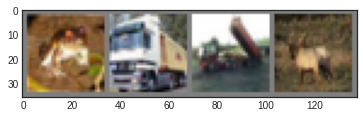

frog	 truck	 truck	 deer	


In [19]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()

dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
print(' '.join('{}\t'.format(class_list[labels[j]]) for j in range(4)))

## 모델 생성

* input size = 4 * 3 * 32 * 32
* output size = 4 * 10
* 모델 조건
> * convolution-layer : 2개 이상 사용
> * maxpooling-layer : 1개 이상 사용
> * fc-layer : 2개 이상 사용
> * activation-function 으로 'relu' 사용

In [40]:
class Net(nn.Module):
    def __init__(self):
      super(Net, self).__init__()

      # in: 3, out: 32, kernel: 3 -> (32-3)/1 + 1 =30
      self.conv1 = nn.Conv2d(3, 32, 3)
      # 이전의 out = 현재 in
      self.conv2 = nn.Conv2d(32, 64, 3)
      self.conv3 = nn.Conv2d(64, 128, 3)

      # affine
      self.fc1 = nn.Linear(128*5*5, 256)
      self.fc2 = nn.Linear(256, 128)
      self.fc3 = nn. Linear(128, 64)
      self.fc4 = nn.Linear(64, 10) # output size

      self.dropout = nn.Dropout(p=0.1, inplace=False)

    def forward(self, x):
      # (2,2) window maxpooling
      x = F.max_pool2d(F.relu(self.conv1(x)), (2,2))
      x = F.relu(self.conv2(x))
      x = F.relu(self.conv3(x))
      x = F.max_pool2d(x, (2,2))

      x = x.view(-1, self.num_flat_features(x)) #flatten
        
      x = F.relu(self.fc1(x))
      x = F.relu(self.fc2(x))
      x = F.relu(self.fc3(x))
      x = self.fc4(x)

      return x

    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
            
        return num_features

In [44]:
myNet = Net().to(device) # gpu에 모델 저장
myNet

Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=3200, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=10, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
)

In [45]:
# input; (4 * 3 * 32 * 32)

input = images.to(device)
input.size()

torch.Size([4, 3, 32, 32])

In [46]:
# output; (4 * 10)

output = myNet.forward(input)
output.size()

torch.Size([4, 10])

In [47]:
# 모델 구조 확인

summary(myNet, input_size=(3, 32, 32), batch_size= 4)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [4, 32, 30, 30]             896
            Conv2d-2            [4, 64, 13, 13]          18,496
            Conv2d-3           [4, 128, 11, 11]          73,856
            Linear-4                   [4, 256]         819,456
            Linear-5                   [4, 128]          32,896
            Linear-6                    [4, 64]           8,256
            Linear-7                    [4, 10]             650
Total params: 954,506
Trainable params: 954,506
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.05
Forward/backward pass size (MB): 1.70
Params size (MB): 3.64
Estimated Total Size (MB): 5.38
----------------------------------------------------------------


## 손실함수와 옵티마이저

In [49]:
criterion = nn.CrossEntropyLoss() # 다중분류; CrossEntropyLoss
optimizer = optim.SGD(myNet.parameters(), lr=0.001, momentum=0.9) # SGD; lr=0.001 & momentum=0.9

## 모델 학습

In [51]:
# epochs = 10

for epoch in range(10):
    running_loss = 0.0

    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()                            # 가중치 초기화

        outputs = myNet(inputs)                            # y_pred
        loss = criterion(outputs, labels)                            # 손실함수를 이용해서 loss계산
        loss.backward()                            # back-propagation
        optimizer.step()                            # 가중치 업데이트

        running_loss += loss.item()
        if i % 2000 == 1999:
            print("Epoch: {}, Batch: {}, Loss: {}".format(epoch+1, i+1, running_loss/2000))
            running_loss = 0.0

Epoch: 1, Batch: 2000, Loss: 2.302274788737297
Epoch: 1, Batch: 4000, Loss: 2.1571643393039706
Epoch: 1, Batch: 6000, Loss: 1.933384123891592
Epoch: 1, Batch: 8000, Loss: 1.7176727637648583
Epoch: 1, Batch: 10000, Loss: 1.6233729336857796
Epoch: 1, Batch: 12000, Loss: 1.5337304228767752
Epoch: 2, Batch: 2000, Loss: 1.4263360818177462
Epoch: 2, Batch: 4000, Loss: 1.399268776036799
Epoch: 2, Batch: 6000, Loss: 1.3195763613581657
Epoch: 2, Batch: 8000, Loss: 1.2457011257223785
Epoch: 2, Batch: 10000, Loss: 1.2520638615824282
Epoch: 2, Batch: 12000, Loss: 1.1825055194105953
Epoch: 3, Batch: 2000, Loss: 1.112857680818066
Epoch: 3, Batch: 4000, Loss: 1.0911075124628842
Epoch: 3, Batch: 6000, Loss: 1.0320067013893277
Epoch: 3, Batch: 8000, Loss: 0.9894282500045374
Epoch: 3, Batch: 10000, Loss: 0.9871148243770004
Epoch: 3, Batch: 12000, Loss: 0.9327704602526501
Epoch: 4, Batch: 2000, Loss: 0.8930510390251875
Epoch: 4, Batch: 4000, Loss: 0.8828696996627842
Epoch: 4, Batch: 6000, Loss: 0.8406061

## 모델의 저장 및 로드

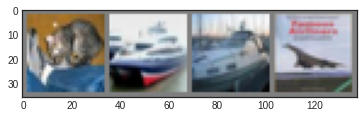

	cat 	ship 	ship 	plane


In [52]:
# 잘 학습된 모델인지 간단히 한 batch에 대해서 확인

dataiter = iter(test_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
print(' '.join('\t{}'.format(class_list[labels[j]]) for j in range(4))) # batch-size = 4

In [53]:
# 저장

PATH = './cifar_net.pth'
torch.save(myNet.state_dict(), PATH)

In [54]:
# 불러오기

Loaded_Net = Net().to(device)
Loaded_Net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

## 모델 테스트
* 조건
> 전체 accuracy가 70% 이상이어야한다.<br>
> 각각의 class에 대한 accuracy는 60% 이상이어야한다.

In [55]:
# 전체 accuracy 확인; 70% 이상 성능값

correct = 0
total = 0

with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)                                              # model객체도 gpu에 저장했음으로, 사용되는 데이터도 gpu에 저장한다.; to(device) 사용
        outputs = Loaded_Net(images)                                              # y_pred
        _, predicted = torch.max(outputs.data, axis=1)  # 확률이 가장 큰 것의 label을 최종 예측값으로 선택
        total += labels.size(0) # 전체 갯수
        correct += (predicted == labels).sum().item()   # 맞춘 갯수
    
    print(100 * correct / total)

70.24


휴,, 턱걸이 ! 신난당

- 어떤 것을 잘 분류했고, 잘 못했는지 확인

In [56]:
# 각각의 class에 대한 accuracy 확인; 각각의 class에 대한 60% 이상 성능값

class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = Loaded_Net(images)
        _, predicted = torch.max(outputs.data, axis=1)
        c = (predicted == labels).squeeze()
        for i in range(4): # 각각의 batch(batch-size : 4) 마다 계싼
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print("Accuracy of {}: {}%".format(class_list[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane: 73.7%
Accuracy of car: 80.7%
Accuracy of bird: 50.7%
Accuracy of cat: 48.7%
Accuracy of deer: 65.7%
Accuracy of dog: 58.2%
Accuracy of frog: 83.2%
Accuracy of horse: 79.9%
Accuracy of ship: 81.2%
Accuracy of truck: 80.4%
